In [1]:
import json

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt  # to make plots
import matplotlib.dates as mdates  # to use ConciseDateFormatter

In [2]:
pilot_data_root = "C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset/"  # change this to your own path

# manifest.tsv
manifest_path = pilot_data_root + "/wearable_blood_glucose/manifest.tsv"
print(manifest_path)

C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset//wearable_blood_glucose/manifest.tsv


In [3]:
dfm = pd.read_csv(manifest_path, sep='\t')
print(dfm.columns)

Index(['participant_id', 'glucose_filepath', 'glucose_level_record_count',
       'average_glucose_level_mg_dl', 'glucose_sensor_sampling_duration_days',
       'glucose_sensor_id', 'manufacturer', 'manufacturer_model_name'],
      dtype='object')


## Analysis for selecting a consistent number of samples among all the participants instead of irregular samples

In [4]:
print(f"Total no. of participants contirbuted to blood glucose are: {dfm['participant_id'].nunique()}  ")
dfm.head()

Total no. of participants contirbuted to blood glucose are: 1049  


,participant_id,glucose_filepath,glucose_level_record_count,average_glucose_level_mg_dl,glucose_sensor_sampling_duration_days,glucose_sensor_id,manufacturer,manufacturer_model_name
0,1001,wearable_blood_glucose/continuous_glucose_moni...,2856,123.304272,11,PG15103578,Dexcom,G6
1,1002,wearable_blood_glucose/continuous_glucose_moni...,2844,116.446203,11,PG15103578,Dexcom,G6
2,1003,wearable_blood_glucose/continuous_glucose_moni...,2856,208.075280,11,PG15103578,Dexcom,G6
3,1004,wearable_blood_glucose/continuous_glucose_moni...,2856,188.661064,11,PG15103578,Dexcom,G6
4,1005,wearable_blood_glucose/continuous_glucose_moni...,2856,262.778361,11,PG15103578,Dexcom,G6


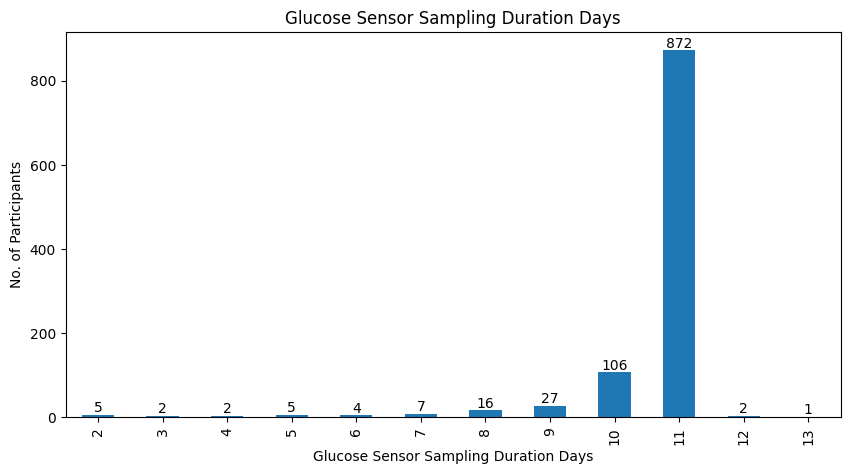

In [5]:
# plot the graph to know where the data is most in glucose_sensor_sampling_duration_days

value_counts = dfm['glucose_sensor_sampling_duration_days'].value_counts().sort_index()
value_counts.plot(kind='bar', figsize=(10, 5))
plt.title('Glucose Sensor Sampling Duration Days')
plt.xlabel('Glucose Sensor Sampling Duration Days')
plt.ylabel('No. of Participants')

# Annotate each bar with the exact number
for index, value in enumerate(value_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

2069
2309
2328


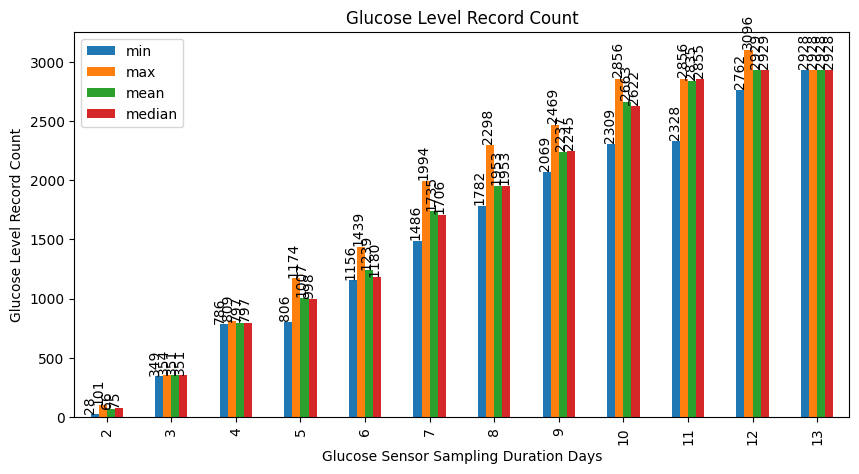

The glucose level record count that covers more than 80% of the participants is: 2856
The glucose level record count that covers more than 90% of the participants is: 2856


In [6]:
# get me the minimum of blood_glucose_count has for 9 - gglucose_sensor_sampling_duration_days
print(dfm[dfm['glucose_sensor_sampling_duration_days'] == 9]['glucose_level_record_count'].min())
print(dfm[dfm['glucose_sensor_sampling_duration_days'] == 10]['glucose_level_record_count'].min())
print(dfm[dfm['glucose_sensor_sampling_duration_days'] == 11]['glucose_level_record_count'].min())

# instead of above can i do a single plot where all this information is present min, max, mean, median of glucose_level_record_count
ax = dfm.groupby('glucose_sensor_sampling_duration_days')['glucose_level_record_count'].agg(['min', 'max', 'mean', 'median']).plot(kind='bar', figsize=(10, 5))
plt.title('Glucose Level Record Count')
plt.xlabel('Glucose Sensor Sampling Duration Days')
plt.ylabel('Glucose Level Record Count')

# Annotate each bar with the exact number vertically
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=90, ha='center', va='bottom')

plt.show()


# Find the glucose level record count that covers more than 80-90% of the participants
total_participants = dfm['participant_id'].nunique()
threshold_80_percent = total_participants * 0.80
threshold_90_percent = total_participants * 0.90

# Calculate cumulative sum of participants for each glucose level record count
cumulative_sum = dfm['glucose_level_record_count'].value_counts().sort_index().cumsum()

# Find the glucose level record count that covers more than 80% of the participants
glucose_count_80_percent = cumulative_sum[cumulative_sum >= threshold_80_percent].index[0]
print(f"The glucose level record count that covers more than 80% of the participants is: {glucose_count_80_percent}")

# Find the glucose level record count that covers more than 90% of the participants
glucose_count_90_percent = cumulative_sum[cumulative_sum >= threshold_90_percent].index[0]
print(f"The glucose level record count that covers more than 90% of the participants is: {glucose_count_90_percent}")

In [7]:
# glucose_sensor_sampling_duration_days greater than or equal to 10 count
print(dfm[dfm['glucose_sensor_sampling_duration_days'] > 9]['participant_id'].nunique())

# glucose_leep_record_count greater than or equal to 2069 count
print(dfm[dfm['glucose_level_record_count'] > 2069]['participant_id'].nunique())

981
1008


## Extract the data from single patient

In [8]:
particpants_metadata_path = pilot_data_root + 'participants.tsv'
df_participants = pd.read_csv(particpants_metadata_path, sep='\t')
print(df_participants.columns)

Index(['participant_id', 'clinical_site', 'study_group', 'age',
       'study_visit_date', 'recommended_split', 'cardiac_ecg', 'clinical_data',
       'environment', 'retinal_flio', 'retinal_oct', 'retinal_octa',
       'retinal_photography', 'wearable_activity_monitor',
       'wearable_blood_glucose'],
      dtype='object')


## Extracting features

In [9]:
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

def get_flatten_dict_from_path(pid):
    pid_cgm = dfm[dfm['participant_id'] == pid]['glucose_filepath'].values[0]
    cgm_path = pilot_data_root + pid_cgm
    print(f"Attempting to open file: {cgm_path}")  # Debugging line

    # read the mHealth formatted data as json
    with open(cgm_path, 'r') as f:
        data = json.load(f)

    # CGM observations are in a list of nested dicts; flatten these 
    list_of_body_dicts = [flatten_json(observation) for observation in data['body']['cgm']]
    return list_of_body_dicts

In [12]:
# Extract the first participant IDs from the manifest
first_two_pids = dfm['participant_id'][:]

low_high_counts = []

for pid in first_two_pids:
    with open(pilot_data_root + dfm[dfm['participant_id'] == pid]['glucose_filepath'].values[0], 'r') as f:
        data = json.load(f)
    low_count = sum(1 for record in data['body']['cgm'] if 'blood_glucose' in record and record['blood_glucose']['value'] == 'Low')
    high_count = sum(1 for record in data['body']['cgm'] if 'blood_glucose' in record and record['blood_glucose']['value'] == 'High')
    
    # Extract start and end date times and transmitter time values
    start_date_time = data['body']['cgm'][0]['effective_time_frame']['time_interval']['start_date_time']
    end_date_time = data['body']['cgm'][-1]['effective_time_frame']['time_interval']['end_date_time']
    
    # Count the length of the dictionary inside cgm
    glucose_level_record_count = len(data['body']['cgm'])
    
    low_high_counts.append({
        'participant_id': pid, 
        'Low': low_count, 
        'High': high_count, 
        'start_date_time': start_date_time, 
        'end_date_time': end_date_time,
        'glucose_level_record_count': glucose_level_record_count
    })
    print(f"Partiicipant ID: {pid}")

# Convert the list of dictionaries to a DataFrame
df_low_high_counts = pd.DataFrame(low_high_counts)

# Save the DataFrame to a CSV file
csv_path_low_high_counts = "low_high_counts.csv"
df_low_high_counts.to_csv(csv_path_low_high_counts, index=False)
print(f"CSV file saved to {csv_path_low_high_counts}")


Partiicipant ID: 1001
Partiicipant ID: 1002
Partiicipant ID: 1003
Partiicipant ID: 1004
Partiicipant ID: 1005
Partiicipant ID: 1006
Partiicipant ID: 1007
Partiicipant ID: 1008
Partiicipant ID: 1009
Partiicipant ID: 1010
Partiicipant ID: 1011
Partiicipant ID: 1012
Partiicipant ID: 1013
Partiicipant ID: 1014
Partiicipant ID: 1015
Partiicipant ID: 1016
Partiicipant ID: 1017
Partiicipant ID: 1018
Partiicipant ID: 1019
Partiicipant ID: 1020
Partiicipant ID: 1021
Partiicipant ID: 1022
Partiicipant ID: 1023
Partiicipant ID: 1024
Partiicipant ID: 1025
Partiicipant ID: 1026
Partiicipant ID: 1027
Partiicipant ID: 1028
Partiicipant ID: 1029
Partiicipant ID: 1030
Partiicipant ID: 1031
Partiicipant ID: 1032
Partiicipant ID: 1033
Partiicipant ID: 1034
Partiicipant ID: 1035
Partiicipant ID: 1036
Partiicipant ID: 1037
Partiicipant ID: 1038
Partiicipant ID: 1039
Partiicipant ID: 1040
Partiicipant ID: 1041
Partiicipant ID: 1042
Partiicipant ID: 1043
Partiicipant ID: 1044
Partiicipant ID: 1045
Partiicipa

In [13]:
csv_path_low_high_counts = "low_high_counts.csv"
# import this json file to see the data
df_low_high_counts = pd.read_csv(csv_path_low_high_counts)
print(df_low_high_counts.head())

   participant_id  Low  High       start_date_time         end_date_time  \
0            1001    0     0  2023-07-27T23:51:23Z  2023-08-06T21:46:23Z   
1            1002  545     0  2023-08-01T20:40:26Z  2023-08-11T18:35:26Z   
2            1003    0     9  2023-08-02T21:16:37Z  2023-08-12T19:11:37Z   
3            1004    0     0  2023-08-08T17:34:15Z  2023-08-18T15:29:15Z   
4            1005    0   121  2023-08-08T21:15:41Z  2023-08-18T19:10:41Z   

   glucose_level_record_count  
0                        2856  
1                        2844  
2                        2856  
3                        2856  
4                        2856  


No. of participants with no 'Low' and 'High' values: 809
Minimum glucose level record count: 349
Maximum glucose level record count: 2928


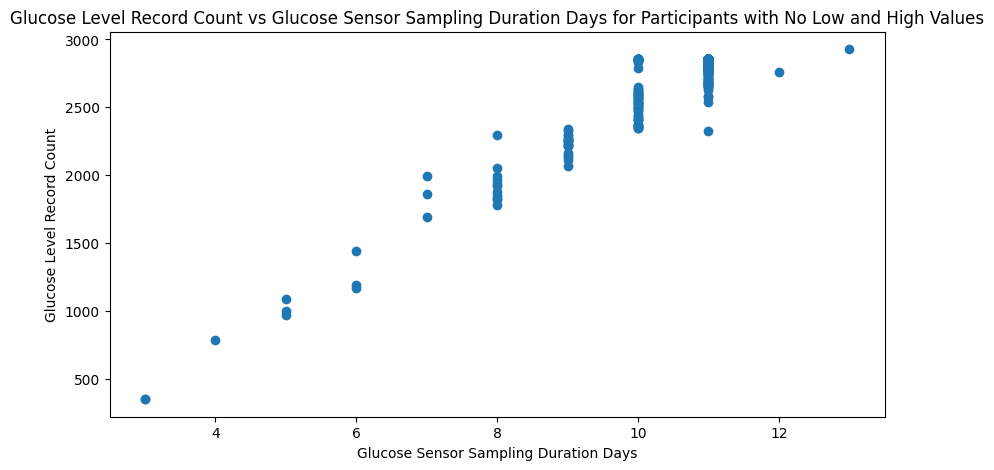

No. of participants with glucose_level_record_count > 2069: 786


In [14]:
# Filter the DataFrame for participants who have both 'Low' and 'High' values as 0
df_no_error = df_low_high_counts[(df_low_high_counts['Low'] == 0) & (df_low_high_counts['High'] == 0)]

# Merge df_no_error with dfm to get the 'glucose_sensor_sampling_duration_days' column
df_no_error = df_no_error.merge(dfm[['participant_id', 'glucose_sensor_sampling_duration_days']], on='participant_id', how='left')

# Print the count of participants who have both 'Low' and 'High' values as 0
print(f"No. of participants with no 'Low' and 'High' values: {df_no_error.shape[0]}")
print(f"Minimum glucose level record count: {df_no_error['glucose_level_record_count'].min()}")
print(f"Maximum glucose level record count: {df_no_error['glucose_level_record_count'].max()}")

# Plot the graph of glucose_level_record_count vs glucose_sensor_sampling_duration_days for df_no_error
plt.figure(figsize=(10, 5))
plt.scatter(df_no_error['glucose_sensor_sampling_duration_days'], df_no_error['glucose_level_record_count'])
plt.title('Glucose Level Record Count vs Glucose Sensor Sampling Duration Days for Participants with No Low and High Values')
plt.xlabel('Glucose Sensor Sampling Duration Days')
plt.ylabel('Glucose Level Record Count')
plt.show()

# Print the count of participants with glucose_level_record_count greater than 2069
print(f"No. of participants with glucose_level_record_count > 2069: {df_no_error[df_no_error['glucose_level_record_count'] > 2069].shape[0]}")

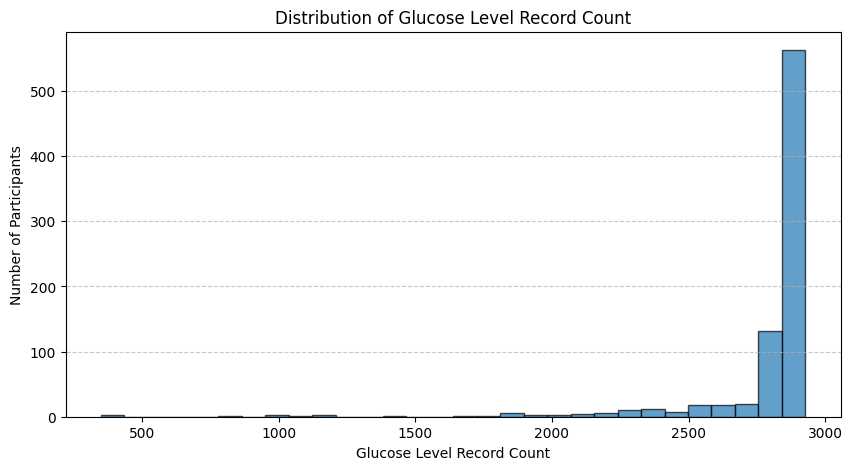

1st percentile: 1459.4 (more than 99% of participants have more than this)
No. of participants with glucose_level_record_count > 1459.4: 800
2nd percentile: 1921.88 (more than 98% of participants have more than this)
No. of participants with glucose_level_record_count > 1921.88: 792
3rd percentile: 2137.56 (more than 97% of participants have more than this)
No. of participants with glucose_level_record_count > 2137.56: 784
5th percentile: 2326.2 (more than 95% of participants have more than this)
No. of participants with glucose_level_record_count > 2326.2: 768
7th percentile: 2471.4 (more than 93% of participants have more than this)
No. of participants with glucose_level_record_count > 2471.4: 752
10th percentile: 2597.8 (more than 90% of participants have more than this)
No. of participants with glucose_level_record_count > 2597.8: 728
25th percentile: 2830.0 (more than 75% of participants have more than this)
No. of participants with glucose_level_record_count > 2830.0: 605
50th (m

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the glucose level record counts
record_counts = df_no_error["glucose_level_record_count"]

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(record_counts, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Glucose Level Record Count")
plt.ylabel("Number of Participants")
plt.title("Distribution of Glucose Level Record Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Calculate lower percentiles
percentiles = np.percentile(record_counts, [1, 2, 3, 5, 7, 10, 25, 50])
percentile_labels = ["1st", "2nd", "3rd", "5th", "7th", "10th", "25th", "50th (median)"]

for label, value in zip(percentile_labels, percentiles):
    if label == "50th (median)":
        percentage = 50
    else:
        percentage = int(label[:-2])
    print(f"{label} percentile: {value} (more than {100 - percentage}% of participants have more than this)")
    print(f"No. of participants with glucose_level_record_count > {value}: {df_no_error[df_no_error['glucose_level_record_count'] > value].shape[0]}")


In [16]:
# Filter participants with glucose_level_record_count >= 2138 and no 'Low' and 'High' values
filtered_participants = df_no_error[(df_no_error['glucose_level_record_count'] >= 2138) & (df_no_error['Low'] == 0) & (df_no_error['High'] == 0)]['participant_id'].tolist()

print(f"Participants with glucose_level_record_count >= 2138 and no 'Low' and 'High' values: {filtered_participants}")

Participants with glucose_level_record_count >= 2138 and no 'Low' and 'High' values: [1001, 1004, 1006, 1008, 1010, 1011, 1012, 1013, 1015, 1016, 1017, 1018, 1019, 1021, 1023, 1024, 1025, 1026, 1028, 1029, 1030, 1031, 1033, 1034, 1036, 1037, 1040, 1043, 1044, 1046, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1059, 1060, 1065, 1066, 1067, 1069, 1070, 1071, 1072, 1074, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1084, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1096, 1097, 1098, 1100, 1101, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1112, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1126, 1127, 1129, 1130, 1131, 1132, 1133, 1135, 1136, 1137, 1138, 1141, 1142, 1143, 1144, 1145, 1146, 1148, 1149, 1150, 1151, 1153, 1155, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1166, 1167, 1168, 1169, 1170, 1171, 1173, 1174, 1175, 1177, 1178, 1179, 1180, 1182, 1183, 1184, 1186, 1188, 1189, 1190, 1191, 1193, 1195, 1196, 1199, 1200, 1201, 1202, 1203, 1204, 12

Here we create batches of csv's file for 100 particants, which is in total `784 participants` so there are 8 csv files, cleaned and preprocessed (means not having any `LOW` or `HIGH` placeholders in  `blood_glucose_value` column)

Also while the creation of these batches we ensure consistency
- no records would have `LOW` or `HIGH` placeholders in `blood_glucose_value` columns 
- by keeping all the records/samples exact for each participant (which is in our case `2138` rows) (and ignore that has above or below 2138 rows)
- Columns are :
- participant_id, 
- time_index (counter from 1 to 2138), timestamp, transmitter_time_value (counter from 7573), age, blood_glucose_value, glucose_change_rate, study_group

In [18]:
# Extract the participant IDs from the manifest
first_few_pids = df_no_error[(df_no_error['glucose_level_record_count'] >= 2138) & (df_no_error['Low'] == 0) & (df_no_error['High'] == 0)]['participant_id'].tolist()

batch_size = 100
all_data_records = []

for batch_start in range(0, len(first_few_pids), batch_size):
    batch_end = min(batch_start + batch_size, len(first_few_pids))
    batch_pids = first_few_pids[batch_start:batch_end]
    
    batch_data_records = []
    
    for pid in batch_pids:
        list_of_body_dicts = get_flatten_dict_from_path(pid)
        if len(list_of_body_dicts) < 2138:
            print(f"Participant {pid} has less than 2138 records. Ignoring this participant.")
            continue

        blood_glucose_values = [record['blood_glucose_value'] for record in list_of_body_dicts]

        data_records = [
            {
                'participant_id': pid,
                'time_index': i + 1,
                'timestamp': record['effective_time_frame_time_interval_start_date_time'],                
                'age': df_participants.loc[df_participants['participant_id'] == pid, 'age'].iloc[0],
                'blood_glucose_value': blood_glucose_values[i],
                'glucose_change_rate': blood_glucose_values[i] - blood_glucose_values[i - 1] if i > 0 else 0,
                'study_group': df_participants.loc[df_participants['participant_id'] == pid, 'study_group'].iloc[0]
            }
            for i, record in enumerate(list_of_body_dicts[:2138 ])  # Limit to 2138 records
        ]

        batch_data_records.extend(data_records)
    
    # Save each batch to a CSV file
    batch_df = pd.DataFrame(batch_data_records)
    batch_csv_path = pilot_data_root + f"/cleaned_data/batch_{batch_start}_{batch_end}.csv"
    batch_df.to_csv(batch_csv_path, index=False)
    print(f"Batch CSV file saved to {batch_csv_path}")
    
    all_data_records.extend(batch_data_records)

# Create a DataFrame for all participants
df_all_participants = pd.DataFrame(all_data_records)

# Convert the timestamp to the desired format
df_all_participants['timestamp'] = pd.to_datetime(df_all_participants['timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Export the DataFrame to a single CSV file
csv_path = pilot_data_root + "/cleaned_data/all_participants_blood_glucose_values.csv"
df_all_participants.to_csv(csv_path, index=False)
print(f"CSV file saved to {csv_path}")

Attempting to open file: C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1001/1001_DEX.json
Attempting to open file: C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1004/1004_DEX.json
Attempting to open file: C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1006/1006_DEX.json
Attempting to open file: C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1008/1008_DEX.json
Attempting to open file: C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1010/1010_DEX.json
Attempting to open file: C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset/wearable_blood_glucose/continuous_glucose_monitoring/dexcom_g6/1011/1011_DEX.json
Atte